# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил (а):**

ФИО, ИТМО ID

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [1]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('flowers', transform=prepare_imgs)

In [4]:
dataset.imgs[2]

('flowers\\daisy\\10172379554_b296050f82_n.jpg', 0)

In [5]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [6]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [7]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [8]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [10]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [13]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [15:16<00:00,  8.81s/it]


[training] Epoch: 0.00. Loss: 1.27. Accuracy: 44.20% 


100%|██████████| 32/32 [01:29<00:00,  2.80s/it]


[validation] Epoch: 0.00. Loss: 1.19. Accuracy: 48.50% 


100%|██████████| 104/104 [15:04<00:00,  8.70s/it]


[training] Epoch: 1.00. Loss: 1.22. Accuracy: 47.39% 


100%|██████████| 32/32 [01:27<00:00,  2.73s/it]


[validation] Epoch: 1.00. Loss: 1.15. Accuracy: 52.00% 


100%|██████████| 104/104 [14:47<00:00,  8.53s/it]


[training] Epoch: 2.00. Loss: 1.13. Accuracy: 51.84% 


100%|██████████| 32/32 [01:26<00:00,  2.69s/it]


[validation] Epoch: 2.00. Loss: 1.16. Accuracy: 53.13% 


100%|██████████| 104/104 [14:49<00:00,  8.55s/it]


[training] Epoch: 3.00. Loss: 1.04. Accuracy: 56.66% 


100%|██████████| 32/32 [01:25<00:00,  2.67s/it]


[validation] Epoch: 3.00. Loss: 1.13. Accuracy: 54.78% 


100%|██████████| 104/104 [14:53<00:00,  8.59s/it]


[training] Epoch: 4.00. Loss: 0.94. Accuracy: 61.45% 


100%|██████████| 32/32 [01:21<00:00,  2.54s/it]


[validation] Epoch: 4.00. Loss: 1.19. Accuracy: 55.18% 


100%|██████████| 104/104 [14:29<00:00,  8.36s/it]


[training] Epoch: 5.00. Loss: 0.84. Accuracy: 65.73% 


100%|██████████| 32/32 [01:23<00:00,  2.62s/it]


[validation] Epoch: 5.00. Loss: 1.31. Accuracy: 56.00% 


100%|██████████| 104/104 [15:27<00:00,  8.91s/it]


[training] Epoch: 6.00. Loss: 0.76. Accuracy: 69.62% 


100%|██████████| 32/32 [01:27<00:00,  2.74s/it]


[validation] Epoch: 6.00. Loss: 1.42. Accuracy: 56.31% 


100%|██████████| 104/104 [14:36<00:00,  8.43s/it]


[training] Epoch: 7.00. Loss: 0.68. Accuracy: 72.82% 


100%|██████████| 32/32 [01:25<00:00,  2.67s/it]


[validation] Epoch: 7.00. Loss: 1.66. Accuracy: 56.34% 


100%|██████████| 104/104 [14:51<00:00,  8.58s/it]


[training] Epoch: 8.00. Loss: 0.62. Accuracy: 75.49% 


100%|██████████| 32/32 [01:23<00:00,  2.62s/it]


[validation] Epoch: 8.00. Loss: 1.85. Accuracy: 56.30% 


100%|██████████| 104/104 [14:34<00:00,  8.41s/it]


[training] Epoch: 9.00. Loss: 0.56. Accuracy: 77.77% 


100%|██████████| 32/32 [01:23<00:00,  2.61s/it]

[validation] Epoch: 9.00. Loss: 2.09. Accuracy: 56.36% 


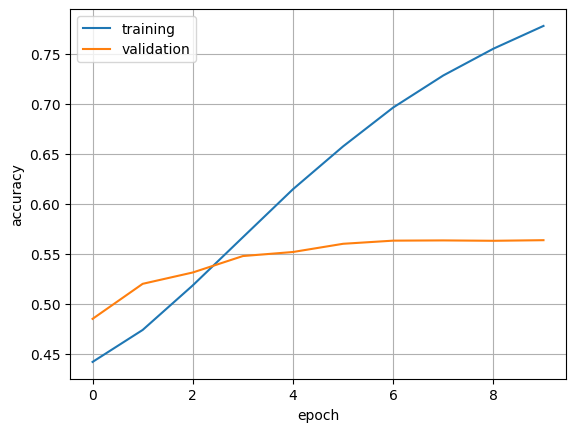

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

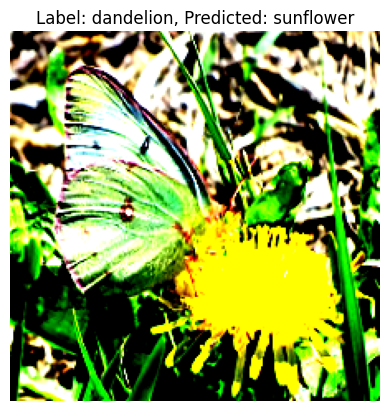

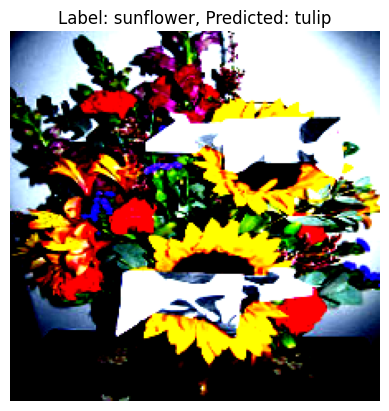

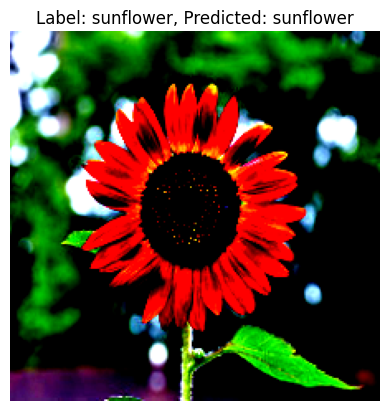

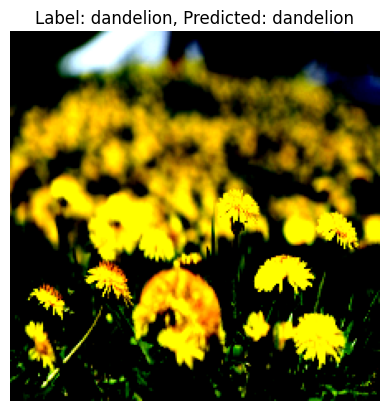

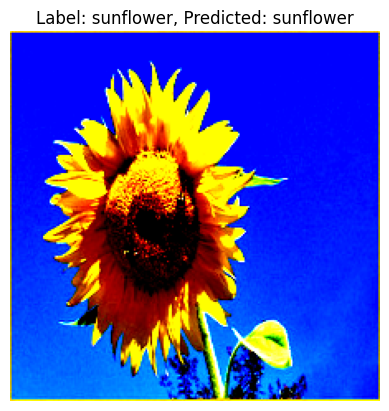

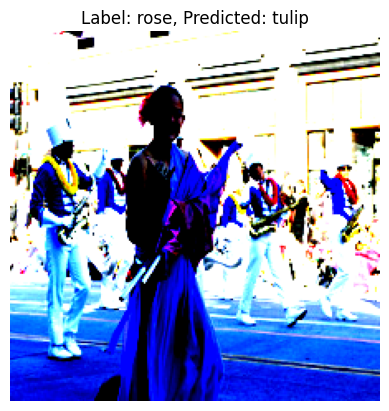

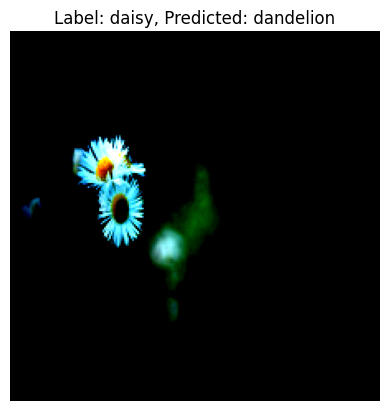

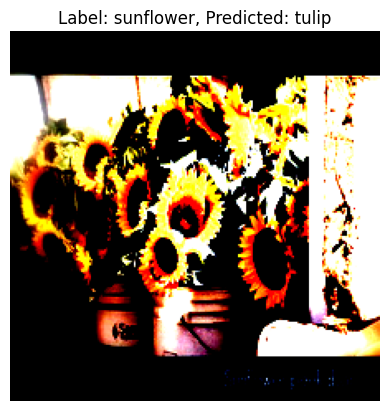

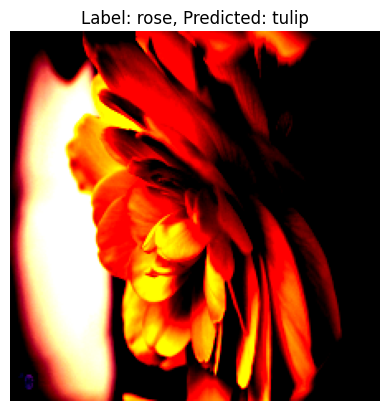

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

Я выбрала для обучения сверточную нейронную сеть DenseNet для задач классификации цветов. Эта архитектура представляет собой модификацию традиционных сверточных нейронных сетей, обеспечивая более эффективное соединение между слоями.

В DenseNet каждый слой напрямую связан со всеми последующими слоями, что является основным принципом, из-за которого сеть получила своё название (Dense — "плотный"). При наличии N слоев в сети образуется N*(N+1)/2 связей. Это означает, что выходные данные каждого сверточного слоя добавляются к входным данным всех последующих слоев, формируя объединённый тензор для входа i-го слоя в виде xi = Hi([x0, x1,…,xi−1)]).

Сеть DenseNet организована в блоки, называемые DenseBlocks, внутри которых размерности выходных карт остаются неизменными. Между этими блоками расположены слои, известные как Transition Layers, которые выполняют свертку и субдискретизацию (pooling) изображений.

In [16]:
import torchvision.models as models

model_densenet_2 = models.densenet121(pretrained=True)
model_densenet_2

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\moonl/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:06<00:00, 4.93MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model_densenet_2) # передайте модель в функцию для "заморозки" градиента

In [18]:
# Меняем последний слой модели
num_classes = 10
model_densenet_2.classifier = nn.Linear(model_densenet_2.classifier.in_features, num_classes)
# Замена последнего слоя необходима для адаптации модели к конкретной задаче классификации
# Количество выходов должно соответствовать количеству классов.  В примере установили num_classes = 10,
# что означает, что мы хотим классифицировать изображения на 10 классов.

In [ ]:
model._____ = _____# Меняем последний слой модели Зачем? Сколькой нужно выходов?

In [19]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model_densenet_2.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [20]:
# Отправляем модель на GPU
model_densenet_2.to(device)
optimizer_2 = torch.optim.Adam(model_densenet_2.parameters(), lr=0.001) # алгоритм оптимизации
loss_track_2, accuracy_track_2 = trainval(model_densenet_2, loaders, optimizer_2, epochs=10)

100%|██████████| 104/104 [04:28<00:00,  2.59s/it]


[training] Epoch: 0.00. Loss: 0.82. Accuracy: 73.95% 


100%|██████████| 32/32 [01:13<00:00,  2.31s/it]


[validation] Epoch: 0.00. Loss: 0.46. Accuracy: 87.50% 


100%|██████████| 104/104 [04:16<00:00,  2.46s/it]


[training] Epoch: 1.00. Loss: 0.63. Accuracy: 80.43% 


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


[validation] Epoch: 1.00. Loss: 0.43. Accuracy: 86.85% 


100%|██████████| 104/104 [04:14<00:00,  2.45s/it]


[training] Epoch: 2.00. Loss: 0.54. Accuracy: 83.11% 


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


[validation] Epoch: 2.00. Loss: 0.39. Accuracy: 87.73% 


100%|██████████| 104/104 [04:13<00:00,  2.44s/it]


[training] Epoch: 3.00. Loss: 0.48. Accuracy: 85.02% 


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


[validation] Epoch: 3.00. Loss: 0.37. Accuracy: 88.20% 


100%|██████████| 104/104 [04:14<00:00,  2.44s/it]


[training] Epoch: 4.00. Loss: 0.45. Accuracy: 86.07% 


100%|██████████| 32/32 [01:12<00:00,  2.25s/it]


[validation] Epoch: 4.00. Loss: 0.35. Accuracy: 88.66% 


100%|██████████| 104/104 [04:13<00:00,  2.44s/it]


[training] Epoch: 5.00. Loss: 0.42. Accuracy: 87.04% 


100%|██████████| 32/32 [01:11<00:00,  2.25s/it]


[validation] Epoch: 5.00. Loss: 0.34. Accuracy: 88.85% 


100%|██████████| 104/104 [04:15<00:00,  2.46s/it]


[training] Epoch: 6.00. Loss: 0.39. Accuracy: 87.61% 


100%|██████████| 32/32 [01:13<00:00,  2.30s/it]


[validation] Epoch: 6.00. Loss: 0.33. Accuracy: 89.07% 


100%|██████████| 104/104 [04:13<00:00,  2.44s/it]


[training] Epoch: 7.00. Loss: 0.38. Accuracy: 88.14% 


100%|██████████| 32/32 [01:11<00:00,  2.24s/it]


[validation] Epoch: 7.00. Loss: 0.32. Accuracy: 89.32% 


100%|██████████| 104/104 [04:18<00:00,  2.49s/it]


[training] Epoch: 8.00. Loss: 0.36. Accuracy: 88.65% 


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


[validation] Epoch: 8.00. Loss: 0.32. Accuracy: 89.53% 


100%|██████████| 104/104 [04:17<00:00,  2.47s/it]


[training] Epoch: 9.00. Loss: 0.35. Accuracy: 89.10% 


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]

[validation] Epoch: 9.00. Loss: 0.31. Accuracy: 89.71% 


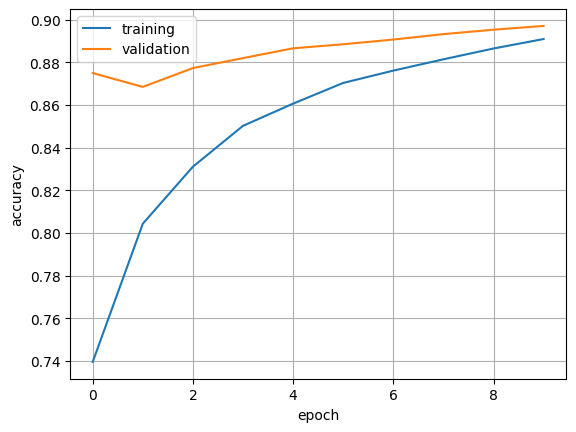

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_2['training'], label='training')
plt.plot(accuracy_track_2['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

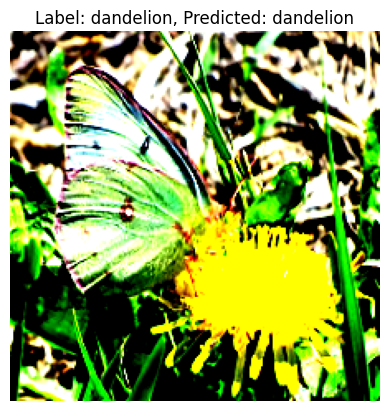

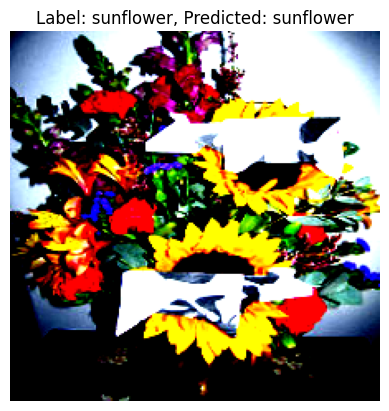

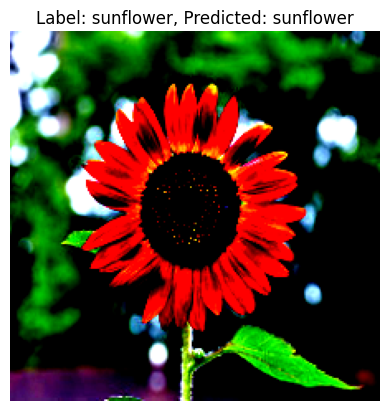

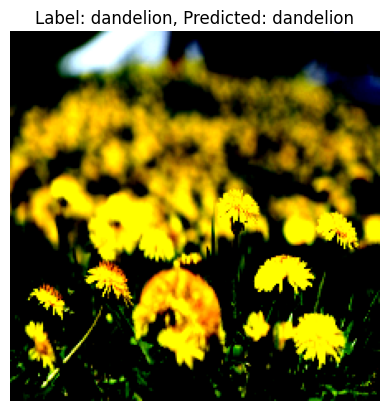

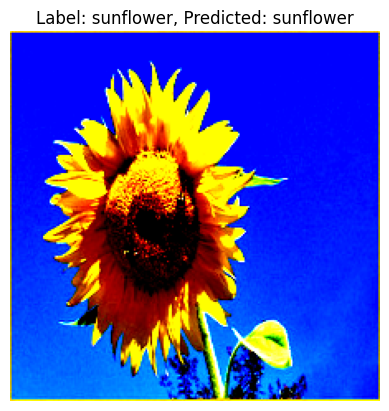

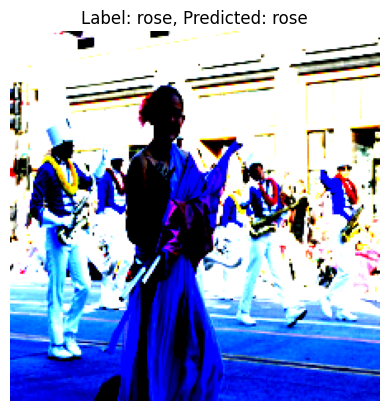

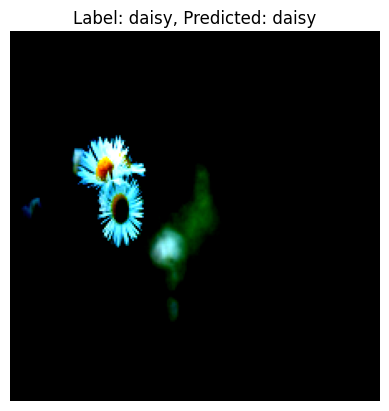

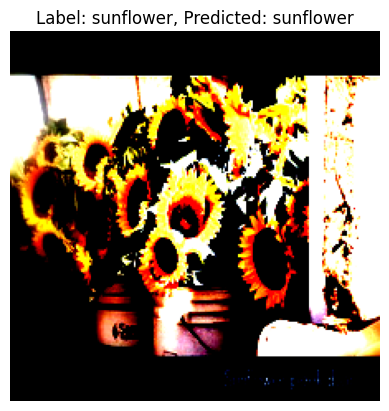

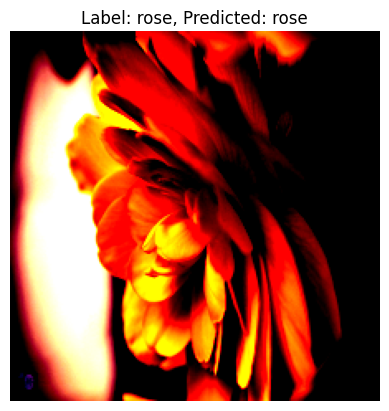

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, enetmodel_dens_2):
    xb = img.unsqueeze(0).to(device)
    yb = model_densenet_2(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model_densenet_2)))
  plt.show()

In [24]:
# Написать свой код здесь
model_3 = nn.Sequential(
            # Первый блок сверток
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),   # слой пакетной нормализации, который помогает стабилизировать и ускорить обучение.
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # Уменьшаем размер до 64 x 16 x 16
            nn.Dropout(0.2),      # Dropout для регуляризации

            # Второй блок сверток
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # Уменьшаем размер до 128 x 8 x 8
            nn.Dropout(0.3),

            # Третий блок сверток
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # Уменьшаем размер до 256 x 4 x 4
            nn.Dropout(0.4),

            # Глобальное усреднение по каждому каналу
            nn.AdaptiveAvgPool2d((1, 1)),   # Уменьшаем размер до 256 x 1 x 1

            # Полносвязные слои
            nn.Flatten(),
            nn.Linear(256, 512),  # Уменьшенное количество нейронов после глобального усреднения
            nn.ReLU(),
            nn.Dropout(0.5),      # Dropout для регуляризации
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 5)     # Выходной слой на 5 классов
)

model_3.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.3, inplace=False)
  (16): Conv2d(128, 256, kernel_size=(3, 3),

In [26]:
batch_size = 32
optimizer_3 = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

In [27]:
loss_track_3, accuracy_track_3 = trainval(model_3, loaders, optimizer_3, epochs=10)

100%|██████████| 104/104 [12:46<00:00,  7.37s/it]


[training] Epoch: 0.00. Loss: 1.30. Accuracy: 43.44% 


100%|██████████| 32/32 [01:35<00:00,  2.98s/it]


[validation] Epoch: 0.00. Loss: 1.23. Accuracy: 45.90% 


100%|██████████| 104/104 [12:33<00:00,  7.24s/it]


[training] Epoch: 1.00. Loss: 1.24. Accuracy: 46.26% 


100%|██████████| 32/32 [01:25<00:00,  2.67s/it]


[validation] Epoch: 1.00. Loss: 1.16. Accuracy: 50.60% 


100%|██████████| 104/104 [12:34<00:00,  7.26s/it]


[training] Epoch: 2.00. Loss: 1.20. Accuracy: 49.15% 


100%|██████████| 32/32 [01:24<00:00,  2.64s/it]


[validation] Epoch: 2.00. Loss: 1.10. Accuracy: 53.83% 


100%|██████████| 104/104 [12:58<00:00,  7.48s/it]


[training] Epoch: 3.00. Loss: 1.16. Accuracy: 51.45% 


100%|██████████| 32/32 [01:23<00:00,  2.61s/it]


[validation] Epoch: 3.00. Loss: 1.10. Accuracy: 53.68% 


100%|██████████| 104/104 [14:08<00:00,  8.16s/it]


[training] Epoch: 4.00. Loss: 1.13. Accuracy: 53.10% 


100%|██████████| 32/32 [01:24<00:00,  2.63s/it]


[validation] Epoch: 4.00. Loss: 1.07. Accuracy: 54.96% 


100%|██████████| 104/104 [12:49<00:00,  7.40s/it]


[training] Epoch: 5.00. Loss: 1.10. Accuracy: 54.53% 


100%|██████████| 32/32 [01:28<00:00,  2.75s/it]


[validation] Epoch: 5.00. Loss: 1.06. Accuracy: 55.40% 


100%|██████████| 104/104 [13:30<00:00,  7.80s/it]


[training] Epoch: 6.00. Loss: 1.08. Accuracy: 55.48% 


100%|██████████| 32/32 [01:27<00:00,  2.72s/it]


[validation] Epoch: 6.00. Loss: 1.07. Accuracy: 55.19% 


100%|██████████| 104/104 [13:04<00:00,  7.54s/it]


[training] Epoch: 7.00. Loss: 1.06. Accuracy: 56.41% 


100%|██████████| 32/32 [01:24<00:00,  2.63s/it]


[validation] Epoch: 7.00. Loss: 1.05. Accuracy: 56.09% 


100%|██████████| 104/104 [13:17<00:00,  7.67s/it]


[training] Epoch: 8.00. Loss: 1.04. Accuracy: 57.22% 


100%|██████████| 32/32 [01:29<00:00,  2.79s/it]


[validation] Epoch: 8.00. Loss: 1.03. Accuracy: 56.86% 


100%|██████████| 104/104 [16:13<00:00,  9.36s/it]


[training] Epoch: 9.00. Loss: 1.03. Accuracy: 58.04% 


100%|██████████| 32/32 [02:12<00:00,  4.14s/it]

[validation] Epoch: 9.00. Loss: 1.01. Accuracy: 57.73% 


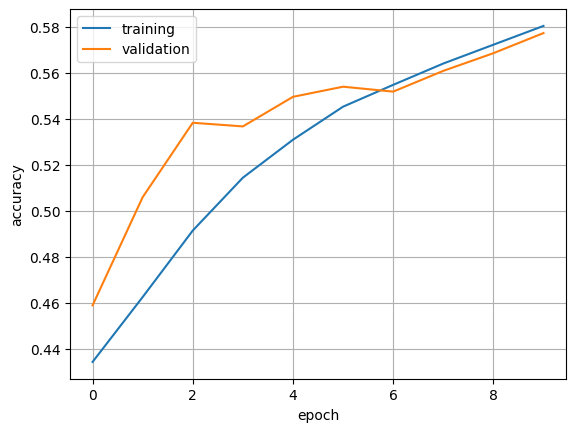

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_3['training'], label='training')
plt.plot(accuracy_track_3['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

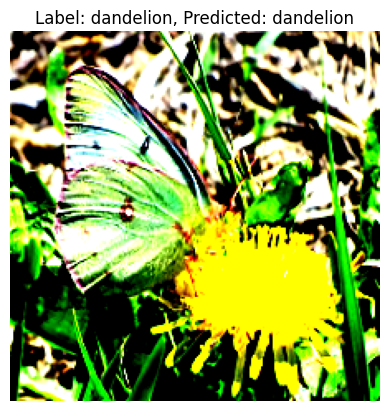

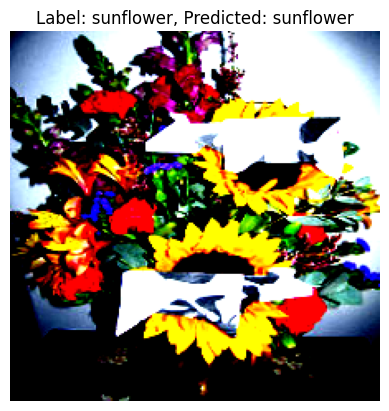

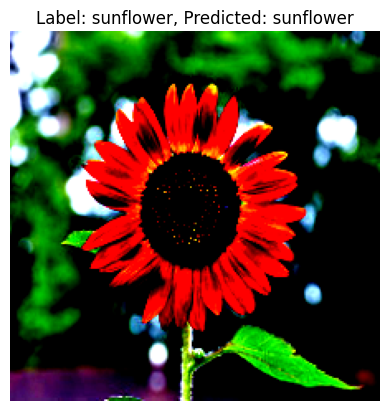

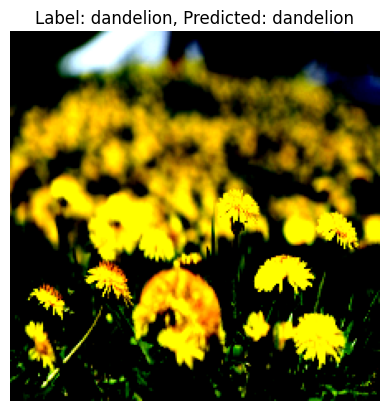

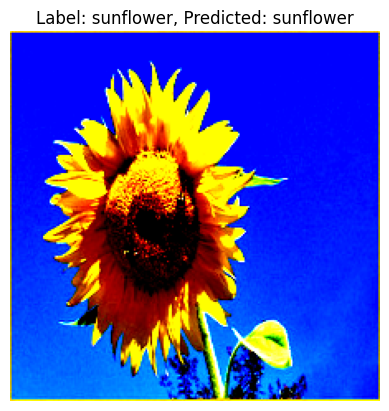

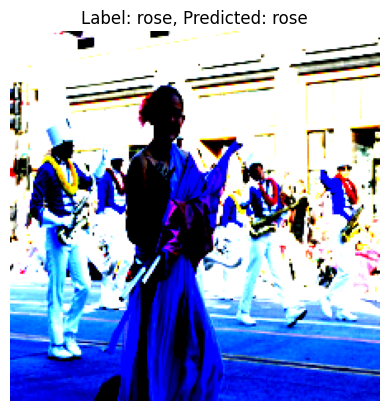

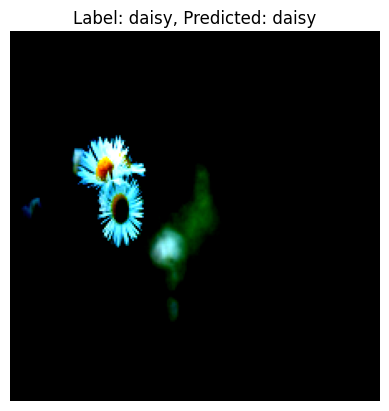

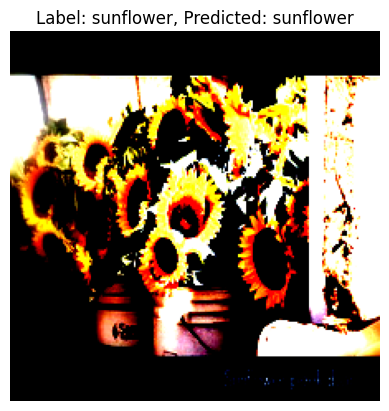

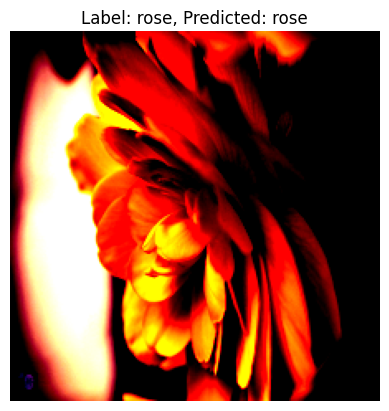

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model_3)))
  plt.show()

3. Сравнение и вузуализация 3-х архитектур

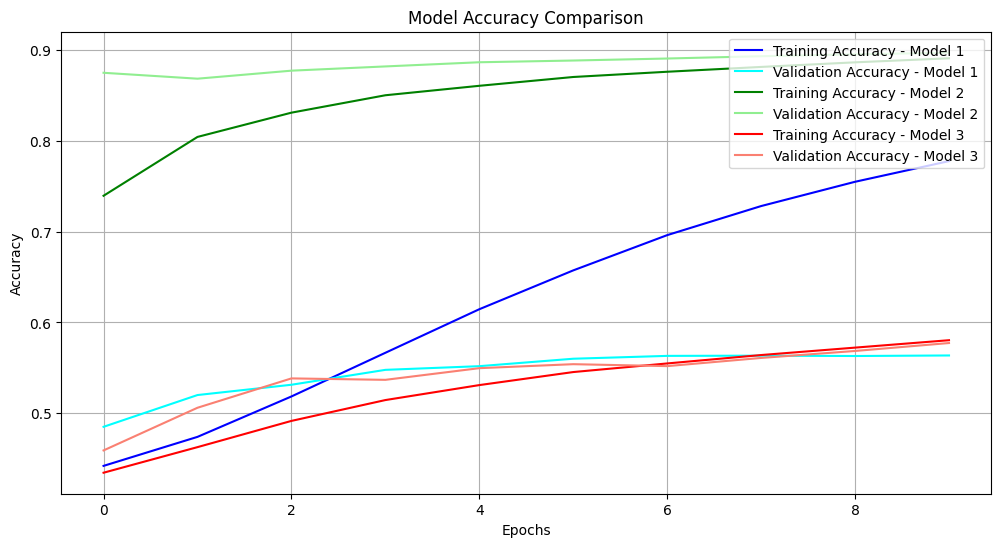

In [31]:
# Написать свой код здесь

import matplotlib.pyplot as plt

# Настройка графика
plt.figure(figsize=(12, 6))

# Для первой модели
plt.plot(accuracy_track['training'], label='Training Accuracy - Model 1', color='blue')
plt.plot(accuracy_track['validation'], label='Validation Accuracy - Model 1', color='cyan')

# Для второй модели
plt.plot(accuracy_track_2['training'], label='Training Accuracy - Model 2', color='green')
plt.plot(accuracy_track_2['validation'], label='Validation Accuracy - Model 2', color='lightgreen')

# Для третьей модели
plt.plot(accuracy_track_3['training'], label='Training Accuracy - Model 3', color='red')
plt.plot(accuracy_track_3['validation'], label='Validation Accuracy - Model 3', color='salmon')

# Настройка подписей и сетки
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Model Accuracy Comparison')
plt.grid()

# Добавление легенды
plt.legend(loc="upper right")

# Показать график
plt.show()





## Вопросы.
**Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.**



*   DenseNet121 — это глубокая сверточная нейронная сеть с 121 слоем, основанная на принципе плотных соединений. Каждый слой получает информацию от всех предыдущих слоев, что улучшает передачу градиентов и способствует эффективному использованию признаков.


**Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?**



*   В отличие от традиционных сверточных сетей, где каждый слой передает информацию только в следующий, в DenseNet каждый слой получает входные данные от всех предыдущих слоев. Это создает "плотные" связи, что позволяет слою использовать все предыдущие признаки. Сеть состоит из нескольких Dense Blocks, каждый из которых включает несколько свёрточных слоев. Внутри блока каждый слой использует выходы всех предыдущих слоев как входные данные.
* Количество слоев - 121, включая свёрточные, активационные и пулинговые слои. Первые слои используют 64 фильтра, а количество фильтров увеличивается в Dense Blocks. Основные свёрточные слои имеют размер 3x3, а первые свёрточные слои — 7x7. DenseNet121 обычно обучается с использованием алгоритмов оптимизации, таких как Adam или SGD, с типичной скоростью обучения 0.001.



**В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?**

* Основные отличия между сверточной нейронной сетью (СНС) и полносвязной нейронной сетью (ПНС) заключаются в архитектуре и способах обработки данных. В ПНС каждый нейрон связан со всеми нейронами следующего слоя, что приводит к большому количеству параметров и требует обработки входных данных в виде одномерных векторов. В отличие от этого, СНС использует свёрточные слои с локальными связями, позволяя эффективно обрабатывать многомерные данные, такие как изображения. Это обеспечивает извлечение локальных признаков с помощью свёрток и значительно снижает количество параметров, что делает СНС более устойчивой к переобучению. В результате, ПНС чаще применяется для задач с табличными данными, тогда как СНС широко используется в задачах компьютерного зрения и других областях, где важна пространственная структура данных.


**Что такое transfer learning? Что такое предобучена нейронная сеть?**

* Transfer learning, или перенос обучения, — это метод в машинном обучении, при котором модель, обученная на одной задаче, используется в качестве отправной точки для обучения на другой, обычно связанной задаче.
* Предобученная нейронная сеть — это модель, которая была обучена на большом наборе данных и может быть адаптирована к новой задаче через дообучение. Использование предобученных сетей позволяет значительно сократить время на обучение и улучшить качество модели, так как они уже содержат полезные признаки и представления, которые могут быть применены к новой задаче.


**Что такое функция для заморозки весов модели?**

* Функция для заморозки весов модели — это механизм, который позволяет временно отключить обновление весов определенных слоев нейронной сети во время обучения. Это используется, например, в контексте переноса обучения, когда предобученная нейронная сеть адаптируется к новой задаче. Замораживая веса некоторых слоев, мы сохраняем их значения и предотвращаем их изменение, что позволяет использовать уже изученные характеристики без дополнительных изменений. Этот подход помогает улучшить производительность модели и ускорить процесс обучения, особенно когда количество доступных данных для новой задачи ограничено.


**Сверточный и пулинговый слой. **

* Сверточный слой выполняет операцию свёртки, которая заключается в применении фильтров (или ядер) к входным данным (например, изображению). Каждый фильтр имеет фиксированный размер (например, 3x3 или 5x5) и перемещается по входному изображению с определенным шагом (stride). На каждом шаге фильтр вычисляет свёртку, что представляет собой сумму произведений соответствующих элементов фильтра и области входного изображения. Результатом работы сверточного слоя является набор активационных карт (feature maps), которые выделяют различные признаки (например, края, текстуры) на входном изображении. Сверточные слои также могут включать нелинейные функции активации, такие как ReLU, для введения нелинейности в модель.
* Пулинговый слой используется для уменьшения размерности активационных карт, что помогает сократить количество параметров и вычислительных затрат, а также делает модель более устойчивой к изменениям в входных данных. Пулинг происходит с использованием того же шага (stride), что и в сверточном слое. В результате применения пулингового слоя размерность выходных данных уменьшается, а сохраняются только наиболее значимые признаки, что позволяет сосредоточиться на важной информации и снизить риск переобучения.
